# LMNO: Nishikawa data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.linear_model

corrientes con las que midieron (en unidades de nA)

In [2]:
currents = np.array([1, 2, 3, 5, 10])

potencial de equilibrio que dan y nuestro potencial de corte (150 mV)

In [3]:
eq_pot = 4.739  # V
vcut = 0.15  # V

Usando que la superficie es de 8.04 $\cdot$ 10$^{-6}$ cm$^2$se obtiene puede obtener el diámetro de la partícula (asumiendo una partícula esférica simple)

In [4]:
d = np.sqrt(0.25 * 8.04e-6 / np.pi)
d

0.0007998767850296815

que equivale a 7.998768 $\mu$m

Para pasar de la corriene en nA a la C-rate que le correspondería

In [5]:
crate = lambda i: 2.5 * i

Lectura de datos obtenidos a mano (ya que la calidad del gráfico es baja y el software no llega a detectar los colores de las curvas) usando [WebPlotDigitzer](https://apps.automeris.io/wpd/)

A partir de ahora utilizamos `galpynostatic`, la herramienta que se introduce aquí

In [6]:
import galpynostatic

In [7]:
dfs = [pd.read_csv(f"data/nishikawa/{i}nA.csv", header=None) for i in currents]

Visualizamos los datos antes de trabajarlos

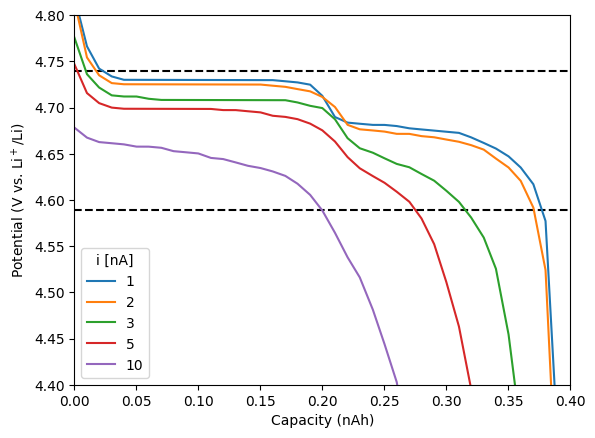

In [8]:
fig, ax = plt.subplots()

# potencial de equilibrio mencionado en el trabajo
ax.axhline(y=eq_pot, color="k", linestyle="--")
# potencial de equilibrio - potencial de corte
ax.axhline(y=eq_pot - vcut, color="k", linestyle="--")
# curvas para cada corriente
for i, df in zip(currents, dfs):
    ax.plot(df.iloc[:, 0], df.iloc[:, 1], label=f"{i}")

ax.set_xlim((0, 0.4))
ax.set_ylim((4.4, 4.8))
ax.set_xlabel("Capacity (nAh)")
ax.set_ylabel(r"Potential (V vs. Li$^+$/Li)")
ax.legend(title="i [nA]")
plt.show()

Ahora, la herramienta desarrollada se encarga de obtener las capacidades de descarga 150 mV por debajo del potencial de equilibrio (obtiene la raíz de un spline interpolado luego de restar el potencial de equilibrio y sumar el de corte)

In [9]:
xmaxs = galpynostatic.preprocessing.get_discharge_capacities(dfs, eq_pot)
xmaxs

array([0.37869504, 0.3709768 , 0.3157027 , 0.2755689 , 0.19977959],
      dtype=float32)

Queda en manos del usuario definir cual es la capacidad máxima del sistema para normalizar los datos entre 0 y 1. Acá elegimos el valor 0.38

In [10]:
xmaxs = xmaxs / 0.38
xmaxs

array([0.99656594, 0.97625476, 0.8307966 , 0.72518134, 0.52573574],
      dtype=float32)

Primero visualizamos estas capacidades en función de las C-rates

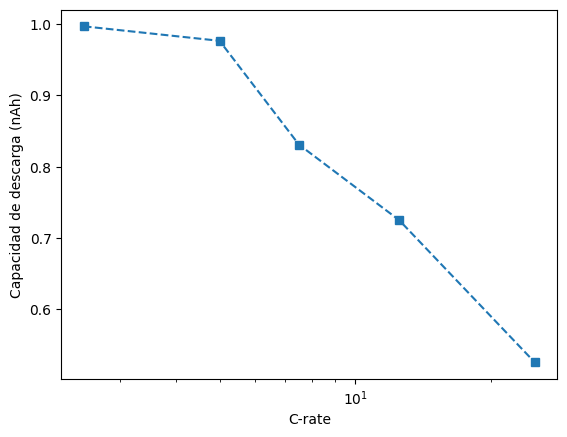

In [11]:
crates = np.asarray([crate(i) for i in currents])

plt.plot(crates, xmaxs, marker="s", linestyle="--")
plt.xlabel("C-rate")
plt.ylabel("Capacidad de descarga (nAh)")
plt.xscale("log")
plt.show()

Ahora con estos datos de capacidad máxima de descarga (normalizada) vs las C rates, podemos encontrar en el mapa el mejor set de parámetros $D$ y $k_0$ que reproducen y minimizan las diferencias de la curva anterior.

In [12]:
from galpynostatic.datasets import load_spherical
from galpynostatic.model import GalvanostaticRegressor

dataset = load_spherical()
gm = GalvanostaticRegressor(dataset, d, 3)

gm.fit(crates, xmaxs)

El coeficiente de difusión que se obtiene de esta cuenta es el siguiente (en cm$^2$/s)

In [13]:
gm.dcoeff_

1.5848931924610332e-09

la constate cinética (cm/s)

In [14]:
gm.k0_

7.943282347242302e-07

y el error cuadrático medio entre los resultados de nishikawa y los valores predichos por el modelo

In [15]:
gm.mse_

0.001383211022111973

Podemos graficar los datos y las predicciones del modelo para visualizar las curvas

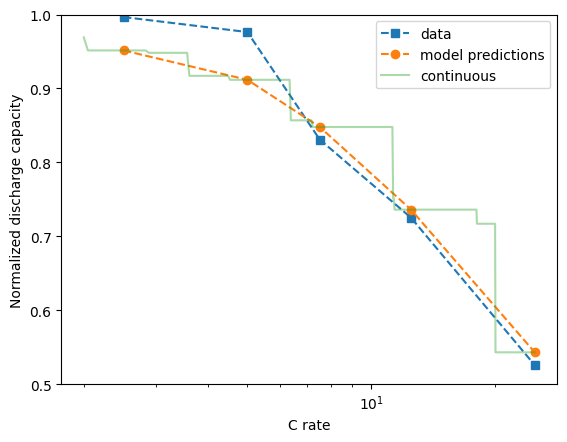

In [16]:
fig, ax = plt.subplots()
gm.plot_vs_data(crates, xmaxs, ax=ax)

x = np.linspace(2, 25, num=500)
ax.plot(x, gm.predict(x), alpha=0.4, label="continuous")

ax.set_ylim((0.5, 1))
ax.set_xscale("log")
ax.set_xlabel("C rate")
ax.set_ylabel("Normalized discharge capacity")

ax.legend()
plt.show()

Hay una gran concordancia entre los datos y las predicciones pero vale la pena mencionar que la curva no es continúa si no que es escalonada y tiene la precisión que se tiene en el mapa realizado por maxi (para mayor precisión podríamos volver a correr estas simulaciones con un delta en $\ell$ y $\Xi$ mucho más pequeño).

Podemos graficar también la región del mapa en la cual se encuentran estos puntos:

/home/ffernandez/.local/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=29,39 m=990 fp=0.000015 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


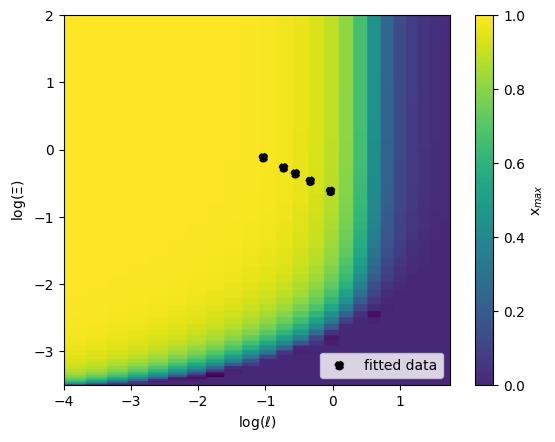

In [17]:
fig, ax = plt.subplots()
gm.plot_in_surface(crates, ax=ax)

ax.legend()
plt.show()

Ahora podemos, con estos parámetros obtenidos, correr las curvas completas con el programa de Maxi. Leemos los archivos obtenidos y los de nishikawa sin alterar por el análisis previo para obtener la curva de descarga:

In [18]:
nishikawas, maxis = [], []
for i in currents:
    nish = pd.read_csv(f"data/nishikawa/{i}nA.csv", header=None)
    nish = nish.rename(columns={0: "capacity", 1: "E"})
    nishikawas.append(nish)
    
    maxi = pd.read_csv(f"data/nishikawa/{i}nA-simulated.csv")
    maxis.append(maxi)

Normalizamos los datos de nishikawa por la capacidad máxima:

In [19]:
capacity_max = 0.38
for nish in nishikawas:
    nish.capacity = nish.capacity / capacity_max

Y ahora graficamos

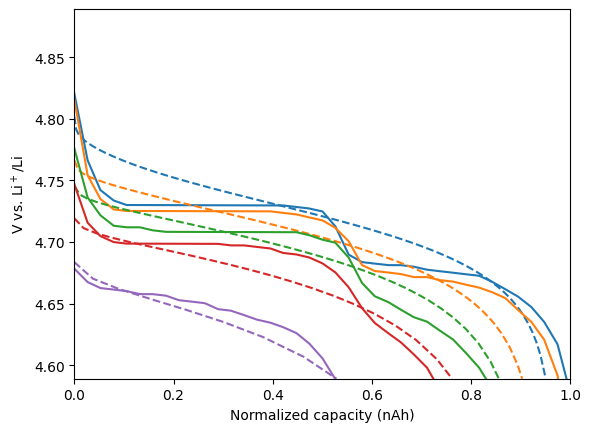

In [20]:
fig, ax = plt.subplots()

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
for nish, maxi, color in zip(nishikawas, maxis, colors):
    ax.plot(nish.capacity, nish.E, color=color)
    ax.plot(maxi.theta, maxi.E, color=color, linestyle="--")
    
ax.set_xlim((0, 1))
ax.set_ylim((eq_pot - vcut, eq_pot + vcut))
ax.set_xlabel("Normalized capacity (nAh)")
ax.set_ylabel(r"V vs. Li$^+$/Li")
plt.show()

Las líneas continuas se corresponden con los experimentos y las discontinuas con las simulaciones.

Como esperabamos, el quiebre de los dos plateaus que se ve en el experimento no es reproducible debido al modelo que se utiliza, aún así podemos apreciar como sólo ajustando con los puntos de las capacidades máximas se logra reproducir el comportamiento cualitativo de las curvas dentro del mismo orden de valores.